## The Full Tutorial Code

[source](https://roguebasin.com/index.php/Complete_Roguelike_Tutorial,_using_python3%2Blibtcod,_part_3_code#Dungeon_generator)

I'm going to go through an annotate the major blocks of this code. This will hep me identify what I needed and what I don't need.

```python
import libtcodpy as libtcod

# actual size of the window
~~SCREEN_WIDTH = 80
SCREEN_HEIGHT = 50

# size of the map
MAP_WIDTH = 80
MAP_HEIGHT = 45

# parameters for dungeon generator
ROOM_MAX_SIZE = 10 
ROOM_MIN_SIZE = 6
MAX_ROOMS = 30

LIMIT_FPS = 20  # 20 frames-per-second maximum


color_dark_wall = libtcod.Color(0, 0, 100)
color_dark_ground = libtcod.Color(50, 50, 150)


class Tile:
    # a tile of the map and its properties

    def __init__(self, blocked, block_sight=None):
        self.blocked = blocked

        # by default, if a tile is blocked, it also blocks sight
        if block_sight is None:
            block_sight = blocked
        self.block_sight = block_sight


class Rect:
    # a rectangle on the map. used to characterize a room.

    def __init__(self, x, y, w, h):
        self.x1 = x
        self.y1 = y
        self.x2 = x + w
        self.y2 = y + h

    def center(self):
        center_x = (self.x1 + self.x2) // 2
        center_y = (self.y1 + self.y2) // 2
        return (center_x, center_y)

    def intersect(self, other):
        # returns true if this rectangle intersects with another one
        return (self.x1 <= other.x2 and self.x2 >= other.x1 and
                self.y1 <= other.y2 and self.y2 >= other.y1)


class Object:
    # this is a generic object: the player, a monster, an item, the stairs...
    # it's always represented by a character on screen.

    def __init__(self, x, y, char, color):
        self.x = x
        self.y = y
        self.char = char
        self.color = color

    def move(self, dx, dy):
        # move by the given amount, if the destination is not blocked
        if not map[self.x + dx][self.y + dy].blocked:
            self.x += dx
            self.y += dy

    def draw(self):
            # set the color and then draw the character that represents this
            # object at its position
        libtcod.console_set_default_foreground(con, self.color)
        libtcod.console_put_char(con, self.x, self.y, self.char, libtcod.BKGND_NONE)

    def clear(self):
        # erase the character that represents this object
        libtcod.console_put_char(con, self.x, self.y, ' ', libtcod.BKGND_NONE)


def create_room(room):
    global map
    # go through the tiles in the rectangle and make them passable
    for x in range(room.x1 + 1, room.x2):
        for y in range(room.y1 + 1, room.y2):
            map[x][y].blocked = False
            map[x][y].block_sight = False


def create_h_tunnel(x1, x2, y):
    global map
    # horizontal tunnel. min() and max() are used in case x1>x2
    for x in range(min(x1, x2), max(x1, x2) + 1):
        map[x][y].blocked = False
        map[x][y].block_sight = False


def create_v_tunnel(y1, y2, x):
    global map
    # vertical tunnel
    for y in range(min(y1, y2), max(y1, y2) + 1):
        map[x][y].blocked = False
        map[x][y].block_sight = False


def make_map():
    global map, player

    # fill map with "blocked" tiles
    map = [
        [Tile(True) for y in range(MAP_HEIGHT)]
        for x in range(MAP_WIDTH)
    ]

    rooms = []
    num_rooms = 0

    for r in range(MAX_ROOMS):
        # random width and height
        w = libtcod.random_get_int(0, ROOM_MIN_SIZE, ROOM_MAX_SIZE)
        h = libtcod.random_get_int(0, ROOM_MIN_SIZE, ROOM_MAX_SIZE)
        # random position without going out of the boundaries of the map
        x = libtcod.random_get_int(0, 0, MAP_WIDTH - w - 1)
        y = libtcod.random_get_int(0, 0, MAP_HEIGHT - h - 1)

        # "Rect" class makes rectangles easier to work with
        new_room = Rect(x, y, w, h)

        # run through the other rooms and see if they intersect with this one
        failed = False
        for other_room in rooms:
            if new_room.intersect(other_room):
                failed = True
                break

        if not failed:
            # this means there are no intersections, so this room is valid
            # "paint" it to the map's tiles
            create_room(new_room)

            # center coordinates of new room, will be useful later
            (new_x, new_y) = new_room.center()

            if num_rooms == 0:
                # this is the first room, where the player starts at
                player.x = new_x
                player.y = new_y
            else:
                # all rooms after the first:
                # connect it to the previous room with a tunnel

                # center coordinates of previous room
                (prev_x, prev_y) = rooms[num_rooms - 1].center()

                # draw a coin (random number that is either 0 or 1)
                if libtcod.random_get_int(0, 0, 1) == 1:
                    # first move horizontally, then vertically
                    create_h_tunnel(prev_x, new_x, prev_y)
                    create_v_tunnel(prev_y, new_y, new_x)
                else:
                    # first move vertically, then horizontally
                    create_v_tunnel(prev_y, new_y, prev_x)
                    create_h_tunnel(prev_x, new_x, new_y)

            # finally, append the new room to the list
            rooms.append(new_room)
            num_rooms += 1
```


### Variable Declarations @ The Top
```python
"""Don't need libtcod or the screen size b/c I won't support a GUI"""
import libtcodpy as libtcod

# actual size of the window
~~SCREEN_WIDTH = 80  
SCREEN_HEIGHT = 50

"""Defining a space for our map will be helpful for placing rooms."""
# size of the map 
MAP_WIDTH = 80 
MAP_HEIGHT = 45


"""Should be able to use 1D rooms, but do want to set a maximum size."""
# parameters for dungeon generator
ROOM_MAX_SIZE = 10 
ROOM_MIN_SIZE = 6
MAX_ROOMS = 30

"""Do not need this or the colors b/c no GUI"""
LIMIT_FPS = 20  # 20 frames-per-second maximum

color_dark_wall = libtcod.Color(0, 0, 100)
color_dark_ground = libtcod.Color(50, 50, 150)
```

### Tile Class

Since we want to use 1D rooms we don't need this. 
```python
class Tile:
    # a tile of the map and its properties

    def __init__(self, blocked, block_sight=None):
        self.blocked = blocked

        # by default, if a tile is blocked, it also blocks sight
        if block_sight is None:
            block_sight = blocked
        self.block_sight = block_sight
```

### Rect Class
Again we don't need this b/c our map can have one dimensional rooms. 
```python
class Rect:
    # a rectangle on the map. used to characterize a room.

    def __init__(self, x, y, w, h):
        self.x1 = x
        self.y1 = y
        self.x2 = x + w
        self.y2 = y + h

    def center(self):
        center_x = (self.x1 + self.x2) // 2
        center_y = (self.y1 + self.y2) // 2
        return (center_x, center_y)

    def intersect(self, other):
        # returns true if this rectangle intersects with another one
        return (self.x1 <= other.x2 and self.x2 >= other.x1 and
                self.y1 <= other.y2 and self.y2 >= other.y1)
```

### Object Class

Not relevant to our problem b/c no GUI, no monster etc. 
```python
class Object:
    # this is a generic object: the player, a monster, an item, the stairs...
    # it's always represented by a character on screen.

    def __init__(self, x, y, char, color):
        self.x = x
        self.y = y
        self.char = char
        self.color = color

    def move(self, dx, dy):
        # move by the given amount, if the destination is not blocked
        if not map[self.x + dx][self.y + dy].blocked:
            self.x += dx
            self.y += dy

    def draw(self):
            # set the color and then draw the character that represents this
            # object at its position
        libtcod.console_set_default_foreground(con, self.color)
        libtcod.console_put_char(con, self.x, self.y, self.char, libtcod.BKGND_NONE)

    def clear(self):
        # erase the character that represents this object
        libtcod.console_put_char(con, self.x, self.y, ' ', libtcod.BKGND_NONE)
```

### Create Functions
I need these three functions in general. They will take a little modification to get them to work for my purposes. 

```python
def create_room(room):
    global map
    # go through the tiles in the rectangle and make them passable
    for x in range(room.x1 + 1, room.x2):
        for y in range(room.y1 + 1, room.y2):
            map[x][y].blocked = False
            map[x][y].block_sight = False


def create_h_tunnel(x1, x2, y):
    global map
    # horizontal tunnel. min() and max() are used in case x1>x2
    for x in range(min(x1, x2), max(x1, x2) + 1):
        map[x][y].blocked = False
        map[x][y].block_sight = False


def create_v_tunnel(y1, y2, x):
    global map
    # vertical tunnel
    for y in range(min(y1, y2), max(y1, y2) + 1):
        map[x][y].blocked = False
        map[x][y].block_sight = False
```


### Make Map

I don't need the tile bit at the top, but other wise this is the key to the whole process. 
```python
def make_map():
    global map, player

    # fill map with "blocked" tiles
    map = [
        [Tile(True) for y in range(MAP_HEIGHT)]
        for x in range(MAP_WIDTH)
    ]

    rooms = []
    num_rooms = 0

    for r in range(MAX_ROOMS):
        # random width and height
        w = libtcod.random_get_int(0, ROOM_MIN_SIZE, ROOM_MAX_SIZE)
        h = libtcod.random_get_int(0, ROOM_MIN_SIZE, ROOM_MAX_SIZE)
        # random position without going out of the boundaries of the map
        x = libtcod.random_get_int(0, 0, MAP_WIDTH - w - 1)
        y = libtcod.random_get_int(0, 0, MAP_HEIGHT - h - 1)

        # "Rect" class makes rectangles easier to work with
        new_room = Rect(x, y, w, h)

        # run through the other rooms and see if they intersect with this one
        failed = False
        for other_room in rooms:
            if new_room.intersect(other_room):
                failed = True
                break

        if not failed:
            # this means there are no intersections, so this room is valid
            # "paint" it to the map's tiles
            create_room(new_room)

            # center coordinates of new room, will be useful later
            (new_x, new_y) = new_room.center()

            if num_rooms == 0:
                # this is the first room, where the player starts at
                player.x = new_x
                player.y = new_y
            else:
                # all rooms after the first:
                # connect it to the previous room with a tunnel

                # center coordinates of previous room
                (prev_x, prev_y) = rooms[num_rooms - 1].center()

                # draw a coin (random number that is either 0 or 1)
                if libtcod.random_get_int(0, 0, 1) == 1:
                    # first move horizontally, then vertically
                    create_h_tunnel(prev_x, new_x, prev_y)
                    create_v_tunnel(prev_y, new_y, new_x)
                else:
                    # first move vertically, then horizontally
                    create_v_tunnel(prev_y, new_y, prev_x)
                    create_h_tunnel(prev_x, new_x, new_y)

            # finally, append the new room to the list
            rooms.append(new_room)
            num_rooms += 1
```

In [1]:
import random
import matplotlib.pyplot as plt


In [ ]:



def create_h_tunnel(x1, x2, y):
    h_tunnel = []
    lb = min(x1, x2)
    ub = max(x1, x2)
    # horizontal tunnel. min() and max() are used in case x1>x2
    for x in range(lb, ub + 1):
        h_tunnel.append((x, y))

    return h_tunnel


def create_v_tunnel(y1, y2, x):
    v_tunnel = []
    lb = min(y1, y2)
    ub = max(y1, y2)
    for y in range(lb, ub + 1):
        v_tunnel.append((x, y))

    return v_tunnel

MAX_ROOMS = 4
MAP_HEIGHT= 20
MAP_WIDTH = 20
rooms = []
num_rooms = 0

all_tunnels = []
for r in range(MAX_ROOMS):
    # random width and height

    # random position without going out of the boundaries of the map
    x = random.randint(1, MAP_WIDTH - 1)
    y = random.randint(1, MAP_HEIGHT - 1)

    new_room = (x, y)

    if num_rooms == 0:
        pass
    else:
        # all rooms after the first:
        # connect it to the previous room with a tunnel

        # center coordinates of previous room
        previous_room = rooms[num_rooms - 1]
        prev_x, prev_y = previous_room[0], previous_room[1]
        # draw a coin (random number that is either 0 or 1)
        # if random.randint(0, 1) == 1:
        # first move horizontally, then vertically
        # h = create_h_tunnel(prev_x, x, prev_y)
        # v = create_v_tunnel(prev_y, y, x)
        # tunnel = h + v
        # else:
        #     # first move vertically, then horizontally
        v = create_v_tunnel(prev_y, y, prev_x)
        h = create_h_tunnel(prev_x, x, y)
        tunnel = v + h

    # finally, append the new room to the list
    all_tunnels.append(tunnel)
    rooms.append(new_room)
    num_rooms += 1

Note, fix the plotting function so I can plot the growth. 

Okay, I have the code generally working, but it draws some extra tunnels. I need to look at this a little more. 

I can probably get around this because in the end I really want to know how the two rooms are connected, not the path between the two rooms. I should be able to use the positions to and a choice between horizontal first and vertical first to decide if the door connecting the two rooms is located on the N, E, S, W of the room. 

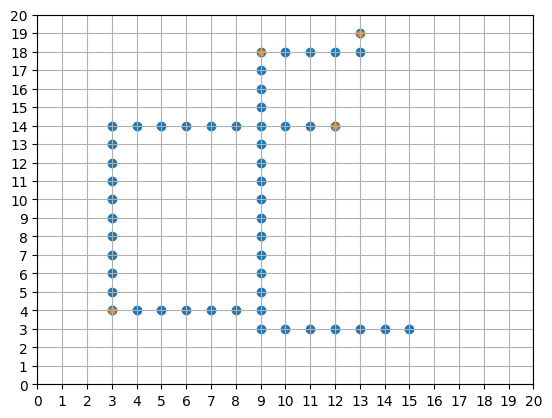

In [44]:
plt.scatter(*zip(*set(all_tunnels)))
plt.scatter(*zip(*rooms), marker='*')
plt.ylim((0, 20))
plt.xlim((0, 20))
plt.xticks(range(0, 21))
plt.yticks(range(0, 21))
plt.grid()
plt.show()